#### Fotis Ntouskas<br><i>Full Time Student ID: f3351813</i>

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 99)

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageFilter, ImageEnhance, ImageOps
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from numpy.random import seed
from tensorflow import set_random_seed
import random
random.seed(2048)
seed(2048)
set_random_seed(2048)

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.regularizers import l2
from keras import backend as K
import gc

Using TensorFlow backend.


## Preprocessing

In [2]:
# Loading dataset's CSVs
train_image_paths = pd.read_csv('train_image_paths.csv', names=['filepath'])
train_labeled_studies = pd.read_csv('train_labeled_studies.csv', dtype={1: str}, names=['path','class'])
valid_image_paths = pd.read_csv('valid_image_paths.csv', names=['filepath'])
valid_labeled_studies = pd.read_csv('valid_labeled_studies.csv', dtype={1: str}, names=['path','class'])

# Manipulating the dataframes
train_image_paths['case'] = train_image_paths['filepath'].apply(lambda x: x.split('/')[2])
train_image_paths['patient'] = train_image_paths['filepath'].apply(lambda x: x.split('/')[3])
train_image_paths['patient_folder'] = train_image_paths['filepath'].apply(lambda x: x.split('/')[4])
train_image_paths['patient_file'] = train_image_paths['filepath'].apply(lambda x: x.split('/')[5])
train_image_paths['merge_path'] = train_image_paths['filepath'].apply(lambda x: x.rpartition('/')[0]+'/')
train_data_df = train_image_paths.merge(train_labeled_studies, how='inner', left_on='merge_path', right_on='path').drop(columns=['merge_path', 'path'])

valid_image_paths['case'] = valid_image_paths['filepath'].apply(lambda x: x.split('/')[2])
valid_image_paths['patient'] = valid_image_paths['filepath'].apply(lambda x: x.split('/')[3])
valid_image_paths['patient_folder'] = valid_image_paths['filepath'].apply(lambda x: x.split('/')[4])
valid_image_paths['patient_file'] = valid_image_paths['filepath'].apply(lambda x: x.split('/')[5])
valid_image_paths['merge_path'] = valid_image_paths['filepath'].apply(lambda x: x.rpartition('/')[0]+'/')
test_data_df = valid_image_paths.merge(valid_labeled_studies, how='inner', left_on='merge_path', right_on='path').drop(columns=['merge_path', 'path'])

train_data_df.head(5)

,filepath,case,patient,patient_folder,patient_file,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,image1.png,1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,image2.png,1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,image3.png,1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,image1.png,1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,image2.png,1


In [3]:
# XR_SHOULDER, XR_HUMERUS, XR_FINGER, XR_ELBOW, XR_WRIST, XR_FOREARM, XR_HAND
# xr_train_df = train_data_df[train_data_df.case=='XR_WRIST']
# xr_test_df = test_data_df[test_data_df.case=='XR_WRIST']

xr_train_df = train_data_df
xr_test_df = test_data_df

#### Shuffling of the training data

In [4]:
xr_train_df = xr_train_df.sample(frac=1).reset_index(drop=True)

#### Defining the functions for processing the images before producing the final dataset

In [5]:
pic_size = 256

# Function for making an image square, enhancing contrast and applying SHARPEN filter
def make_square(im, min_size=256, fill_color=0):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('L', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    enhancer = ImageEnhance.Contrast(new_im)
    enhanced_im = enhancer.enhance(1.1)
    return enhanced_im.filter(ImageFilter.SHARPEN)

def invert_image(im):
    return ImageOps.invert(im)

def make_dataset(datafr_var, test=False):
    train_x = []
    train_y = []
    patient_nr_y = []

    # Make each image square and of size 256x256
    for index, row in datafr_var.iterrows():
        im = Image.open(row['filepath']).convert('L')
        squared = make_square(im)
        resized = squared.resize((pic_size,pic_size))
        
        # For the train set only, augment the data by applying random rotations and inversions (negative)
        if test==False:
            rotated_r = resized.rotate(random.randint(10,30))
            if index%2: rotated_r = invert_image(rotated_r)
            numpy_rotated_r_pic = np.array(rotated_r)/255
            train_x.append(numpy_rotated_r_pic)
            train_y.append(row['class'])

            rotated_l = resized.rotate(random.randint(330,350))
            if not index%2: rotated_l = invert_image(rotated_l)
            numpy_rotated_l_pic = np.array(rotated_l)/255
            train_x.append(numpy_rotated_l_pic)
            train_y.append(row['class'])
        
        numpy_pic = np.array(resized)/255
        train_x.append(numpy_pic)
        train_y.append(row['class'])
        if test: patient_nr_y.append(row['patient'][7:]+'_'+row['patient_folder'])
        
    return train_x, train_y, patient_nr_y

#### Produce the final dataset

In [6]:
xr_train_x, xr_train_y, blank = make_dataset(xr_train_df)
xr_train_x = np.asarray(xr_train_x)
xr_train_y = np.asarray(xr_train_y)

xr_test_x, xr_test_y, xr_patient_y = make_dataset(xr_test_df, test=True)
xr_test_x = np.asarray(xr_test_x)
xr_test_y = np.asarray(xr_test_y)
xr_patient_y = np.asarray(xr_patient_y)

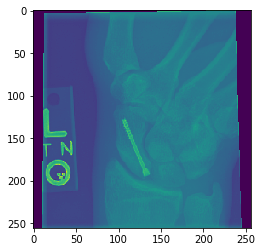

In [7]:
plt.imshow(xr_train_x[24332])

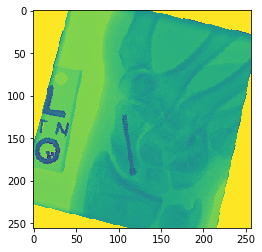

In [8]:
plt.imshow(xr_train_x[24331])

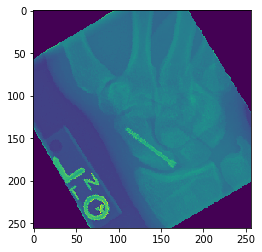

In [9]:
plt.imshow(xr_train_x[24330])

In [10]:
X_train = xr_train_x.reshape(np.shape(xr_train_x)[0],pic_size,pic_size,1)
y_train = xr_train_y
X_test = xr_test_x.reshape(np.shape(xr_test_x)[0],pic_size,pic_size,1)
y_test = xr_test_y

## Model definition & Evaluation

In [11]:
def plot_history(hs, epochs, metric):
    plt.clf()
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 16
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric))
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric))
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

In [12]:
def train_model():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(pic_size, pic_size, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
    
    hs = model.fit(
        x=X_train,
        y=y_train,
        validation_split=0.1,
        epochs=50,
        verbose=1,
        shuffle=True,
        batch_size=64,
        callbacks=[es]
    )
    
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

In [13]:
mura_model, mura_hs = train_model()
mura_eval = mura_model.evaluate(X_test, y_test, verbose=1)

Train on 99381 samples, validate on 11043 samples
Epoch 1/50
99381/99381 [==============================] - 573s 6ms/step - loss: 0.6765 - binary_accuracy: 0.5947 - val_loss: 0.6712 - val_binary_accuracy: 0.5954
Epoch 2/50
99381/99381 [==============================] - 564s 6ms/step - loss: 0.6644 - binary_accuracy: 0.6077 - val_loss: 0.6325 - val_binary_accuracy: 0.6442
Epoch 3/50
99381/99381 [==============================] - 562s 6ms/step - loss: 0.6280 - binary_accuracy: 0.6529 - val_loss: 0.6076 - val_binary_accuracy: 0.6720
Epoch 4/50
99381/99381 [==============================] - 572s 6ms/step - loss: 0.5989 - binary_accuracy: 0.6789 - val_loss: 0.5921 - val_binary_accuracy: 0.6775
Epoch 5/50
99381/99381 [==============================] - 573s 6ms/step - loss: 0.5738 - binary_accuracy: 0.6977 - val_loss: 0.5780 - val_binary_accuracy: 0.6935
Epoch 6/50
99381/99381 [==============================] - 583s 6ms/step - loss: 0.5423 - binary_accuracy: 0.7220 - val_loss: 0.5735 - val_bi

Train Loss     : 0.28368
Validation Loss: 0.69882
Test Loss      : 0.82700
---
Train Accuracy     : 0.87934
Validation Accuracy: 0.69746
Test Accuracy      : 0.68658


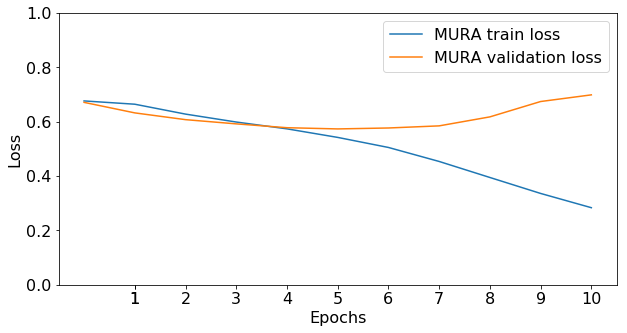

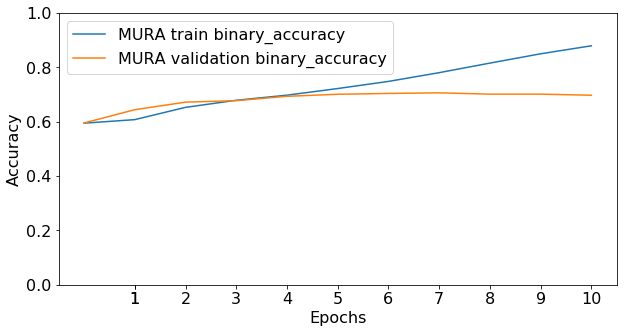

In [14]:
print("Train Loss     : {0:.5f}".format(mura_hs.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mura_hs.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mura_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mura_hs.history['binary_accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mura_hs.history['val_binary_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(mura_eval[1]))


# Plot train and validation error per epoch.
plot_history(hs={'MURA': mura_hs}, epochs=10, metric='loss')
plot_history(hs={'MURA': mura_hs}, epochs=10, metric='binary_accuracy')

In [15]:
predictions = mura_model.predict(X_test)

## Classification Reports and Kappa Measure

#### Get all the indices separated by study from the test set

In [16]:
study_indices = []
tmp_list = []
for idx, study in enumerate(xr_patient_y):
    if idx == 0: previous_study = study
    if study != previous_study:
        study_indices.append(tmp_list)
        tmp_list = []
    tmp_list.append(idx)
    previous_study = study

#### Define the voting functions to be used for classifying each study

In [17]:
# Here the votes are simply rounded
def get_vote_round(lst):
    return round(sum([round(x) for x in np.ravel(lst)]) / len(lst))

# Here if there exists a vote of certainty over a threshold, it will be dominant. Otherwise, votes are simply rounded
def get_vote_roundmax(lst):
    threshold = 0.85
    if max(np.ravel(lst)) >= threshold:
        return 1
    else:
        return get_vote_round(lst)
    
# Here the true list is shrunk, so that there is only one element for each study   
def concat_true_lst(lst):
    return round(sum([round(x) for x in lst]) / len(lst))

# This produces 3 lists given the above functions
def voting_list(true_lst, pred_lst, indices):
    new_true_list = []
    new_pred_list_round = []
    new_pred_list_roundmax = []
    for outer_idx in indices:
        new_true_list.append(concat_true_lst(list(map(int, true_lst[outer_idx]))))
        new_pred_list_round.append(get_vote_round(list(pred_lst[outer_idx])))
        new_pred_list_roundmax.append(get_vote_roundmax(list(pred_lst[outer_idx])))
    return new_true_list, new_pred_list_round, new_pred_list_roundmax

In [18]:
true_lst, pred_lst_round, pred_lst_roundmax = voting_list(xr_test_y, predictions, study_indices)

#### Simple round voting scheme

In [19]:
print(classification_report(true_lst, pred_lst_round, target_names=['negative (0)','positive (1)']))

              precision    recall  f1-score   support

negative (0)       0.67      0.90      0.77       660
positive (1)       0.79      0.45      0.58       538

   micro avg       0.70      0.70      0.70      1198
   macro avg       0.73      0.68      0.67      1198
weighted avg       0.72      0.70      0.68      1198



In [20]:
confusion_matrix(true_lst, pred_lst_round)

array([[596,  64],
       [295, 243]], dtype=int64)

In [21]:
print('Kappa score: ' + str(cohen_kappa_score(true_lst, pred_lst_round)))

Kappa score: 0.3693608884744083


#### Voting scheme with certainty threshold

In [22]:
print(classification_report(true_lst, pred_lst_roundmax, target_names=['negative (0)','positive (1)']))

              precision    recall  f1-score   support

negative (0)       0.70      0.87      0.78       660
positive (1)       0.77      0.55      0.64       538

   micro avg       0.72      0.72      0.72      1198
   macro avg       0.74      0.71      0.71      1198
weighted avg       0.73      0.72      0.71      1198



In [23]:
confusion_matrix(true_lst, pred_lst_roundmax)

array([[572,  88],
       [243, 295]], dtype=int64)

In [24]:
print('Kappa score: ' + str(cohen_kappa_score(true_lst, pred_lst_roundmax)))

Kappa score: 0.42634647377938517
